In [1]:
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np

import multiprocessing as mp
import time
from functools import partial

# need qutip to run adaptive solver
import qutip as qt

import adaptive_rwa_solver as ars

## set up system (here we have just a qubit coupled to a driven resonator)

In [2]:
omega_q = 1.0 # qubit frequency
omega_r = 1.0 # resonator frequency
g = 0.1 # coupling strength
kappa = 0.001 # resonator leakage rate
gamma = 0.001 # qubit leakage rate
zeta = 0.001 # drive strength
omega_d = 1.0
T = 0.005 # temperature in Kelvin
kb = 1.3806e-23
h = 6.626e-34
hbar = h / (2*np.pi)
beta = 1./(kb*T)
giga = 1e9

res_dim = 10

a  = qt.tensor(qt.qeye(2), qt.destroy(res_dim))
sm = qt.tensor(qt.destroy(2), qt.qeye(res_dim))
sx = sm + sm.dag()
x = a + a.dag()

H = omega_r * a.dag() * a + omega_q * sm.dag() * sm + g * (sm * a.dag() + sm.dag() * a)
# Standard J-C Hamiltonian
eigensystem = H.eigenstates()
evals = eigensystem[0]
evecs = eigensystem[1]
print(evals)

[ 0.          0.9         1.1         1.85857864  2.14142136  2.82679492
  3.17320508  3.8         4.2         4.7763932   5.2236068   5.75505103
  6.24494897  6.73542487  7.26457513  7.71715729  8.28284271  8.7
  9.3        10.        ]


## set up decoherence rates

In [3]:
rates = np.zeros(shape=(2*res_dim, 2*res_dim))
# note these rates are rates between eigenstates of dressed system, so they consist of matrix elements of annhilation op/
# sigma_minus in dressed basis
for index1 in range(2*res_dim):
    for index2 in range(index1):
        exponent = hbar * beta * giga * (evals[index1] - evals[index2])
        # downward rate (contribution from both resonator and qubit leakage, and finite temperature)
        rates[index1][index2] =  (gamma * abs(sx.matrix_element(evecs[index2],evecs[index1]))**2 + kappa * abs(x.matrix_element(evecs[index2],evecs[index1]))**2) * (np.exp(exponent) / (np.exp(exponent) - 1.0))
        # upward rate
        rates[index2][index1] =  rates[index1][index2] *  np.exp(-exponent)   

## solve for steady-state

In [4]:
open_qubit_resonator = ars.DrivenOpenSystem(H,rates,zeta*a,omega_d)

In [5]:
start = time.time()
rho_s = open_qubit_resonator.adaptive_rwa_solve()
end = time.time()
print('time elapsed:')
print(end - start)

[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10]
time elapsed:
15.45469856262207


## calculate resonator transmission

In [37]:
transmission = abs(qt.expect(a, rho_s))
print(transmission)

0.02242046915492492


## calculate resonator transmission for a range of tones (done in parallel) 

In [4]:
# need this function to parallelize
def parallel_map(f, a_list, *args, **kw):
    pool=mp.Pool(*args, **kw)

    result=pool.map(f, a_list)

    try:
        pool.close()
        pool.terminate()
    except:
        pass

    return result

number_of_threads = 24

NameError: name 'transmission_10mK' is not defined

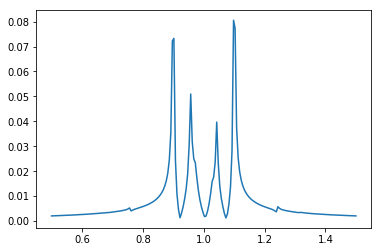

In [5]:
frequency_list = np.linspace(omega_r - 0.5, omega_r + 0.5,200)
transmission_5mK = np.empty(shape=(1, len(frequency_list)))
#transmission_10mK = np.empty(shape=(1, len(frequency_list)))
#transmission_20mK = np.empty(shape=(1, len(frequency_list)))
def parallel_solve(frequency):
    open_qubit_resonator = ars.DrivenOpenSystem(H,rates,zeta*a,frequency)
    rho_s = open_qubit_resonator.adaptive_rwa_solve()
    return rho_s
    
rho_s = parallel_map(parallel_solve, frequency_list, number_of_threads)
transmission_5mK = [abs(qt.expect(a, r))  for omega,r in enumerate(rho_s)]

plt.plot(frequency_list, transmission_5mK)
plt.plot(frequency_list, transmission_10mK)
plt.plot(frequency_list, transmission_20mK)

plt.show()